# Assignment Week 8
Data Augmentation and AE Networks usinng MNIST

In [99]:
#MNIST is a build in Pytorch dataset
from torchvision import datasets as dts
from torchvision.transforms import ToTensor
train = dts.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test = dts.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

In [100]:
train[0][0].shape

torch.Size([1, 28, 28])

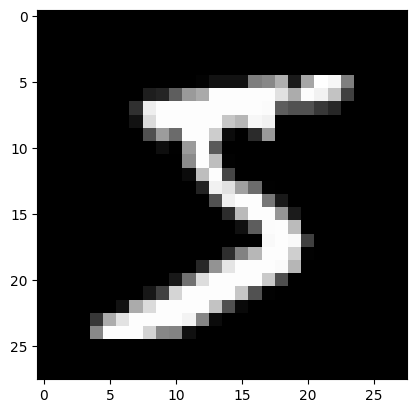

In [101]:
import matplotlib.pyplot as plt
plt.imshow(train[0][0].reshape((28,28)), cmap='gray')

## Exercise 1
Augment the training data with 6 differnet suitable augmentations
* use the PyTorch augmentation framework -> https://pytorch.org/vision/stable/transforms.html
* visualize some examples

In [102]:
from torchvision.transforms import v2
import torch
import matplotlib.pyplot as plt


transforms = v2.Compose([
    v2.RandomResizedCrop(size=(28, 28), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(degrees=(0, 180)),
    v2.RandomErasing(p=0.3, scale=(0.02, 0.2)),
    v2.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    v2.RandomApply(transforms=[v2.RandomCrop(size=(28, 28))], p=0.5),

    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.1307], std=[0.3081]),
])




In [103]:
train.data.shape


torch.Size([60000, 28, 28])

In [104]:
# creating augmented traindata

augmented =  [transforms(img.unsqueeze(0)) for img in train.data]

In [105]:
augmented = torch.stack(augmented)

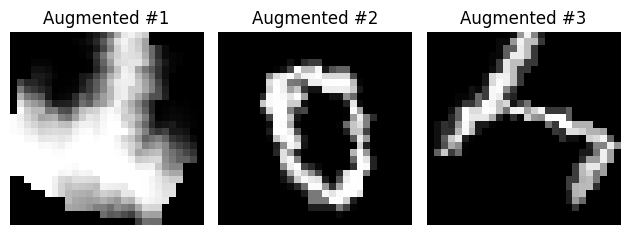

In [106]:
images = augmented[:3]


for i, img in enumerate(images):
    plt.subplot(1, 3, i+1)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"Augmented #{i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Exercise 2
Build and train a MLP Autoencoder with
* 2 Encoder Layers
* 2 Decoder Layers
* Identity Loss

In [136]:
class AE(torch.nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = torch.nn.Linear(
            in_features=kwargs["input_shape"], out_features=128)

        self.encoder_output_layer = torch.nn.Linear(
            in_features=128, out_features=128)

        self.decoder_hidden_layer = torch.nn.Linear(
            in_features=128, out_features=128)

        self.decoder_output_layer = torch.nn.Linear(
            in_features=128, out_features=kwargs["input_shape"])

    def forward(self, features):
      activation = self.encoder_hidden_layer(features)
      activation = torch.relu(activation)
      code = self.encoder_output_layer(activation)
      code = torch.relu(code)
      activation = self.decoder_hidden_layer(code)
      activation = torch.relu(activation)
      activation = self.decoder_output_layer(activation)
      reconstructered = torch.relu(activation)
      return reconstructered

In [137]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [135]:
def train_model(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      X = X.view(X.size(0), -1) # Flatten input

      # Compute prediction error
      pred = model(X)
      loss = loss_fn(pred, X) # Compare with original input

      # Backpropagation
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      if batch % 100 == 0:
          loss, current = loss.item(), (batch + 1) * len(X)
          print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [138]:
def test_model(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            X = X.view(X.size(0), -1) # Flatten input
            pred = model(X)
            test_loss += loss_fn(pred, X).item()
    test_loss /= num_batches
    print(f"Test Error: Avg loss: {test_loss:>8f} \n")

In [139]:
model = AE(input_shape=784)
model.to(device) # transfer model to GPU
model.train()    # set to train mode
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.003, momentum=0.9)

In [140]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train, batch_size=64, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=False)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_model(train_loader, model, criterion, optimizer)
    test_model(test_loader, model, criterion)
print("Done!")

Epoch 1
-------------------------------
loss: 0.110713  [   64/60000]
loss: 0.103623  [ 6464/60000]
loss: 0.102231  [12864/60000]
loss: 0.103762  [19264/60000]
loss: 0.101957  [25664/60000]
loss: 0.102902  [32064/60000]
loss: 0.110175  [38464/60000]
loss: 0.100870  [44864/60000]
loss: 0.102832  [51264/60000]
loss: 0.101024  [57664/60000]


TypeError: object of type 'function' has no len()

## Exercise 3


Use the Gaussian Noise as augmentation and your AE to remove the noise.
* visualize input and output examples

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

## Exercise 4
Clustering: extract the latent space representations of the train data and apply K-Means (fron Scikit-Learn) with k=10. Use the data lables to evaluate the cluter quality.